In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv("./Sleep_Efficiency.csv")
df.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [3]:
#fill na
df["Awakenings"] = df["Awakenings"].fillna(value=df["Awakenings"].mean())
df["Caffeine consumption"] = df["Caffeine consumption"].fillna(value=df["Caffeine consumption"].mean())
df["Alcohol consumption"] = df["Alcohol consumption"].fillna(value=df["Alcohol consumption"].mean())
df["Exercise frequency"] = df["Exercise frequency"].fillna(value=df["Exercise frequency"].mean())

df["Gender"] = df["Gender"].apply(lambda x: 1 if x == "Male" else 0)
df["Smoking status"] = df["Smoking status"].apply(lambda x: 1 if x == "Yes" else 0)

In [4]:
#adding new column based on sleep duration, awakening, and sleep efficiency
def conditions(row):
  if row["Sleep duration"] in [7,8] and row["Awakenings"] <= 2 and row["Sleep efficiency"] >= 0.80:
    return 1
  else:
    return 0

df["Good sleep quality"] = df.apply(conditions, axis=1)

In [5]:
#drop columns 
df = df.drop(columns=["ID", "Bedtime", "Wakeup time", "REM sleep percentage", "Deep sleep percentage", "Light sleep percentage", "Sleep duration",	"Sleep efficiency", "Awakenings"])

In [37]:
xs = df.drop(columns="Good sleep quality")
ys= df["Good sleep quality"]
xs

,Age,Gender,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,0,0.000000,0.0,1,3.0
1,69,1,0.000000,3.0,1,3.0
2,40,0,0.000000,0.0,0,3.0
3,40,0,50.000000,5.0,1,1.0
4,57,1,0.000000,3.0,0,3.0
...,...,...,...,...,...,...
447,27,0,0.000000,0.0,0,5.0
448,52,1,25.000000,0.0,0,3.0
449,40,0,23.653396,3.0,1,0.0
450,45,1,0.000000,0.0,0,3.0


In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 100
tf_df = tf.data.Dataset.from_tensor_slices((xs, ys))
tf_df.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

tf_df

<_TensorSliceDataset element_spec=(TensorSpec(shape=(6,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
TRAIN_SET = 316
VAL_SET = 68
TEST_SET = 68

train_x = xs[:TRAIN_SET]
train_y = ys[:TRAIN_SET]

val_x = xs[TRAIN_SET:TRAIN_SET + VAL_SET]
val_y = ys[TRAIN_SET:TRAIN_SET + VAL_SET]

test_x = xs[TRAIN_SET + VAL_SET:]
test_y = ys[TRAIN_SET + VAL_SET:]

xs.shape

(452, 6)

In [56]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(xs.shape[1],)),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=["auc","accuracy"])

In [65]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
history = model.fit(train_x, train_y,
                    epochs=100,
                    validation_data=(val_x, val_y))

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7413 - auc: 0.6238 - loss: 0.5517 - val_accuracy: 0.7059 - val_auc: 0.5200 - val_loss: 0.6087
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6970 - auc: 0.6807 - loss: 0.5816 - val_accuracy: 0.7059 - val_auc: 0.5350 - val_loss: 0.6011
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7268 - auc: 0.6405 - loss: 0.5706 - val_accuracy: 0.7059 - val_auc: 0.5183 - val_loss: 0.6010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7331 - auc: 0.6964 - loss: 0.5440 - val_accuracy: 0.7059 - val_auc: 0.5161 - val_loss: 0.6072
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7438 - auc: 0.6958 - loss: 0.5434 - val_accuracy: 0.7059 - val_auc: 0.5300 - val_loss: 0.6024
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7056 - auc: 0.7263 - loss: 0.5586 - val_accuracy: 0.7206 - val_auc: 0.5322 - val_loss: 0.5977
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms

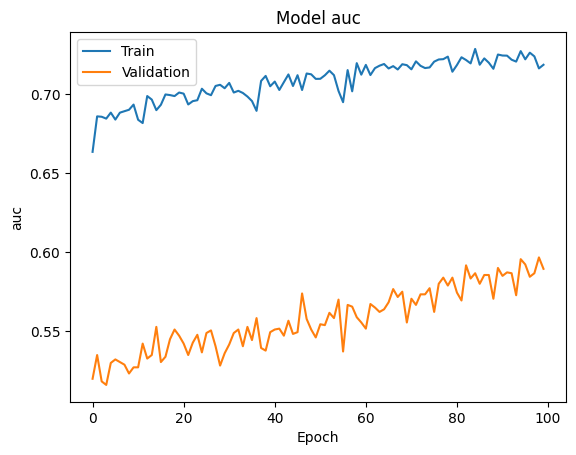

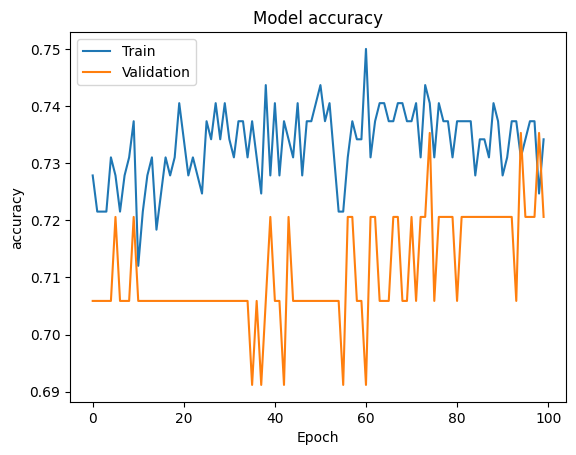

In [69]:
acc = history.history['auc']
val_acc = history.history['val_auc']

plt.plot(acc, label='Training auc')
plt.plot(val_acc, label='Validation auc')
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()  

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()  


In [71]:
model.evaluate(test_x, test_y)
# print('Test accuracy:', test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5935 - auc: 0.6502 - loss: 0.6305


[0.5979536175727844, 0.6651469469070435, 0.6323529481887817]

In [76]:
# 	Age,	Gender, Caffeine consumption,	Alcohol consumption,	Smoking status,	Exercise frequency
predict = np.expand_dims([60, 1, 0.0, 0.0, 0.0, 5.0], axis=0)
model.predict(predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[0.50602925]], dtype=float32)